# Dictionarization

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("not_final3.csv")
df = df.rename(columns={'Sport_-1': 'Sport'})

# List of sports to exclude
excluded_sports = ['climbing', 'Fitness', 'Headis']

# Filter out excluded sports
df = df[~df['Sport'].isin(excluded_sports)]

# Define parameters including 'label'
parameters = ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label']

# Initialize a dictionary to store processed data for each sport
sport_data_dict = {}

for sport_name in df['Sport'].unique():
    sport_dict = {'Year': []}
    
    # Initialize a DataFrame for Year
    all_years = pd.Series(dtype=int)
    
    for parameter in parameters:
        param_columns = [col for col in df.columns if col.startswith(f"{parameter}_")]
        
        if not param_columns:
            continue
        
        # Melt the data for this parameter
        melted_data = df[df['Sport'] == sport_name][['Sport'] + param_columns].melt(
            id_vars='Sport', var_name='Year', value_name=f'{parameter}_Value'
        )
        melted_data['Year'] = melted_data['Year'].str.extract(r'(\d+)').astype(int)  # Extract year as int
        melted_data = melted_data.sort_values('Year')

        if all_years.empty:
            all_years = melted_data['Year']
        else:
            all_years = pd.concat([all_years, melted_data['Year']]).drop_duplicates().sort_values()
        
        # Align parameter data with all years
        melted_data = melted_data.set_index('Year').reindex(all_years).reset_index()
        
        # Handle missing data based on parameter type
        if parameter == 'drug':
            melted_data[f'{parameter}_Value'] = melted_data[f'{parameter}_Value'].fillna(0)  # For drug, fill missing with 0
        elif parameter in ['popularity', 'CV']:
            # For popularity and CV, treat 0 as missing and replace with NaN
            melted_data[f'{parameter}_Value'] = melted_data[f'{parameter}_Value'].replace(0, np.nan)
        else:
            # Preserve NaN for other parameters
            melted_data[f'{parameter}_Value'] = melted_data[f'{parameter}_Value']
        
        # Store parameter values aligned by Year
        sport_dict[parameter] = melted_data[f'{parameter}_Value'].values

    # Ensure that Year is included
    sport_dict['Year'] = all_years.values
    
    # Convert the dictionary to a DataFrame
    sport_data_dict[sport_name] = pd.DataFrame(sport_dict)

# Example usage: print data for a specific sport
for sport, data in sport_data_dict.items():
    data.set_index('Year', inplace=True)  # Ensure Year is the index
    

    print(f"\nData for {sport}:")
    print(data.head())



Data for Alpine Skiing:
      drug  equity  popularity  normalizedcountry  CV  label
Year                                                        
1896   0.0     NaN         NaN                NaN NaN      0
1900   0.0     NaN         NaN                NaN NaN      0
1904   0.0     NaN         NaN                NaN NaN      0
1906   0.0     NaN         NaN                NaN NaN      0
1908   0.0     NaN         NaN                NaN NaN      0

Data for Alpinism:
      drug  equity  popularity  normalizedcountry  CV  label
Year                                                        
1896   0.0     NaN         NaN                NaN NaN      0
1900   0.0     NaN         NaN                NaN NaN      0
1904   0.0     NaN         NaN                NaN NaN      0
1906   0.0     NaN         NaN                NaN NaN      0
1908   0.0     NaN         NaN                NaN NaN      0

Data for Archery:
      drug    equity  popularity  normalizedcountry        CV  label
Year         

In [2]:
for sport, data in sport_data_dict.items():
    print(f"Checking {sport}:")
    print(data.columns)
    if 'Year' not in data.columns:
        print(f"Year column is missing in {sport}")
    else:
        print(data.head())  # View the first few rows


Checking Alpine Skiing:
Index(['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label'], dtype='object')
Year column is missing in Alpine Skiing
Checking Alpinism:
Index(['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label'], dtype='object')
Year column is missing in Alpinism
Checking Archery:
Index(['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label'], dtype='object')
Year column is missing in Archery
Checking Art Competitions:
Index(['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label'], dtype='object')
Year column is missing in Art Competitions
Checking Athletics:
Index(['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label'], dtype='object')
Year column is missing in Athletics
Checking Badminton:
Index(['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label'], dtype='object')
Year column is missing in Badminton
Checking Baseball:
Index(['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label'], d

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def fill_drug_column(df):
    df['drug'] = df['drug'].ffill().bfill()  # Forward fill, then backward fill
    return df

def regression_imputation(df, column, degree=2, min_val=None, max_val=None):
    # Extract available data
    available_data = df[df[column].notna()]
    missing_data = df[df[column].isna()]

    if len(available_data) < 2:
        print(f"Skipping regression for {column}: Not enough data.")
        return df[column]

    # If there's no missing data, return the column as is
    if missing_data.empty:
        return df[column]
    
    # Prepare features (Year as X) and target (column as y)
    X_train = available_data.index.values.reshape(-1, 1)  # Year as feature
    y_train = available_data[column].values

    # Use polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_train)
    
    model = LinearRegression()
    model.fit(X_poly, y_train)

    # Predict missing values
    X_missing = missing_data.index.values.reshape(-1, 1)
    X_missing_poly = poly.transform(X_missing)
    predictions = model.predict(X_missing_poly)

    # Clamp predictions within the specified range
    if min_val is not None:
        predictions = np.maximum(predictions, min_val)
    if max_val is not None:
        predictions = np.minimum(predictions, max_val)
    
    df.loc[missing_data.index, column] = predictions
    
    return df[column]

def fill_continuous_columns_with_regression(df, degree=1):
    for col in ['equity', 'popularity', 'normalizedcountry', 'CV']:
        min_val, max_val = None, None
        if col == 'normalizedcountry':
            min_val, max_val = 0.0, 1.0
        elif col == 'equity':
            min_val, max_val = 0.0, 0.5
        elif col == 'popularity':  # Cap popularity between 0 and 0.3
            min_val, max_val = 0.0, 0.3

        if df[col].notna().sum() < 2:
            print(f"Skipping {col} due to insufficient data.")
            continue
        df[col] = regression_imputation(df, col, degree=degree, min_val=min_val, max_val=max_val)
    return df

# Example Usage for Filling Missing Data
for sport, data in sport_data_dict.items():
    data = fill_drug_column(data)  # Fill drug column as before
    sport_data_dict[sport] = fill_continuous_columns_with_regression(data)

# Display the filled DataFrame for Alpine Skiing as an example
print(sport_data_dict['Alpine Skiing'].head(30))


Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normaliz

In [4]:
import pandas as pd

# Initialize an empty list to store each sport's data
all_sports_data = []

# Iterate over the sport_data_dict to process each sport's DataFrame
for sport, df in sport_data_dict.items():
    df = df.reset_index()  # Ensure 'Year' is a column, not an index
    df['Sport'] = sport  # Add a new column to indicate the sport name
    all_sports_data.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
combined_sport_data = pd.concat(all_sports_data, ignore_index=True)

# Display the first few rows of the combined DataFrame
combined_sport_data


,Year,drug,equity,popularity,normalizedcountry,CV,label,Sport
0,1896,0.0,0.316822,0.029387,0.023511,0.775016,0,Alpine Skiing
1,1900,0.0,0.318375,0.029939,0.031223,0.780618,0,Alpine Skiing
2,1904,0.0,0.319929,0.030490,0.038936,0.786221,0,Alpine Skiing
3,1906,0.0,0.320706,0.030766,0.042793,0.789022,0,Alpine Skiing
4,1908,0.0,0.321482,0.031042,0.046649,0.791823,0,Alpine Skiing
...,...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,1,Wrestling
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,1,Wrestling
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,1,Wrestling
2013,2020,0.0,0.333333,0.027252,0.356916,0.663988,1,Wrestling


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data
df = pd.read_csv('not_final3.csv')

# Select specific columns by their names
selected_columns = df[['Sport_-1', 'estimate per event_2024']]
selected_columns = selected_columns.drop([65, 66, 67])
selected_columns = selected_columns.rename(columns={'estimate per event_2024': 'sustain', 'Sport_-1': 'Sport'})

# Apply log scale normalization to the sustain column
selected_columns['sustain'] = np.log1p(selected_columns['sustain'])

# Apply Min-Max normalization
scaler = MinMaxScaler()
selected_columns['sustain'] = scaler.fit_transform(selected_columns[['sustain']])

# Display the normalized data
print(selected_columns)


               Sport   sustain
0      Alpine Skiing  0.567916
1           Alpinism  0.464455
2            Archery  0.344805
3   Art Competitions  0.000000
4          Athletics  0.666640
..               ...       ...
60        Tug-Of-War  0.323558
61        Volleyball  0.484022
62        Water Polo  0.526599
63     Weightlifting  0.426390
64         Wrestling  0.437871

[65 rows x 2 columns]


In [6]:
# Merge the DataFrames on the 'Sport' column
merged_df = combined_sport_data.merge(selected_columns, on='Sport', how='left').dropna()

# Display the resulting DataFrame
merged_df

,Year,drug,equity,popularity,normalizedcountry,CV,label,Sport,sustain
0,1896,0.0,0.316822,0.029387,0.023511,0.775016,0,Alpine Skiing,0.567916
1,1900,0.0,0.318375,0.029939,0.031223,0.780618,0,Alpine Skiing,0.567916
2,1904,0.0,0.319929,0.030490,0.038936,0.786221,0,Alpine Skiing,0.567916
3,1906,0.0,0.320706,0.030766,0.042793,0.789022,0,Alpine Skiing,0.567916
4,1908,0.0,0.321482,0.031042,0.046649,0.791823,0,Alpine Skiing,0.567916
...,...,...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,1,Wrestling,0.437871
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,1,Wrestling,0.437871
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,1,Wrestling,0.437871
2013,2020,0.0,0.333333,0.027252,0.356916,0.663988,1,Wrestling,0.437871


Class Distribution:
label
1    880
0    744
Name: count, dtype: int64


/tmp/ipykernel_56789/1134520909.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=merged_df, palette='viridis')


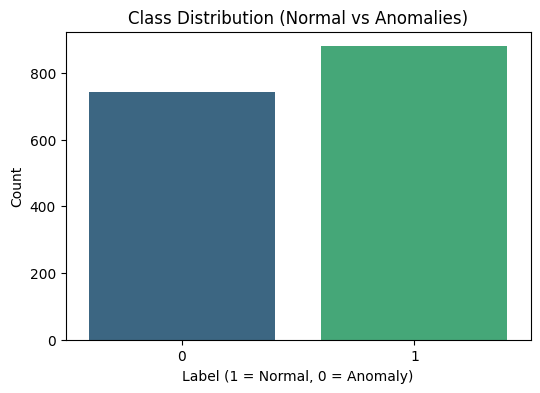


Summary Statistics for Normal Data:
              Year        drug      equity  popularity  normalizedcountry  \
count   880.000000  880.000000  880.000000  880.000000         880.000000   
mean   1968.570455    0.420455    0.226100    0.035195           0.159990   
std      36.596587    3.759014    0.244709    0.042446           0.154847   
min    1896.000000    0.000000    0.000000    0.000270           0.000000   
25%    1936.000000    0.000000    0.000000    0.012690           0.070000   
50%    1972.000000    0.000000    0.172912    0.022648           0.110000   
75%    2000.000000    0.000000    0.432261    0.036666           0.210000   
max    2024.000000   86.000000    1.000000    0.352037           1.005000   

               CV  label     sustain  
count  880.000000  880.0  880.000000  
mean     0.784311    1.0    0.511166  
std      0.169643    0.0    0.094268  
min      0.176383    1.0    0.000000  
25%      0.684045    1.0    0.464455  
50%      0.769611    1.0    0.52659

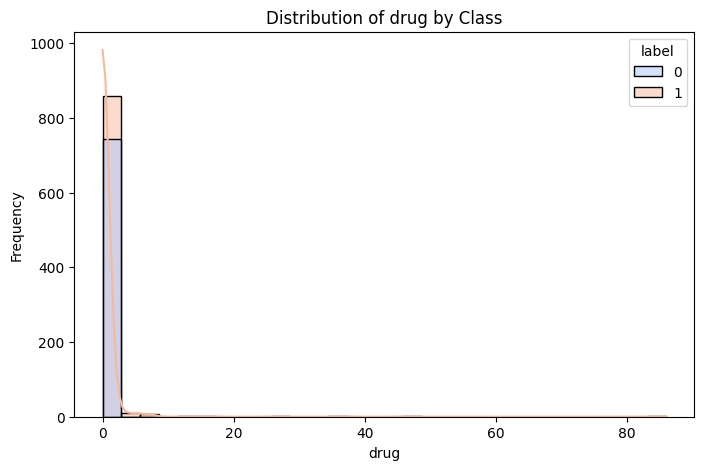

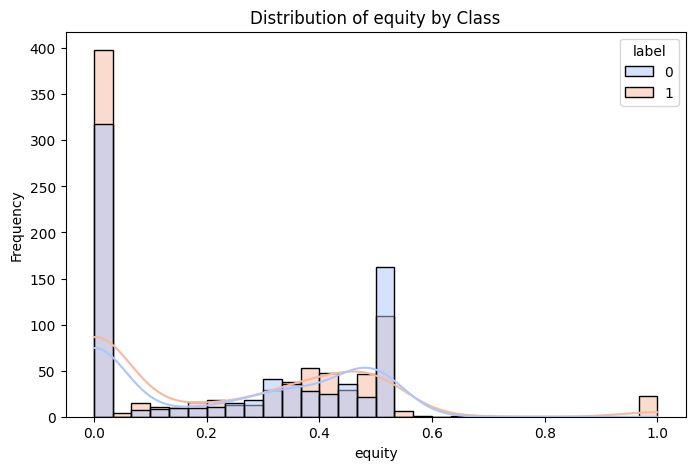

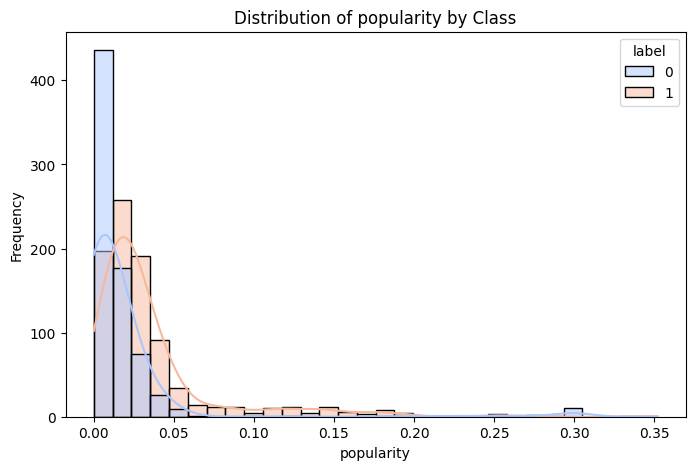

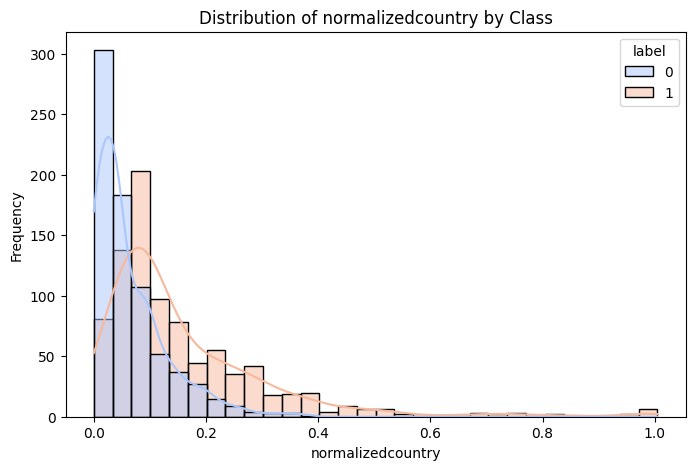

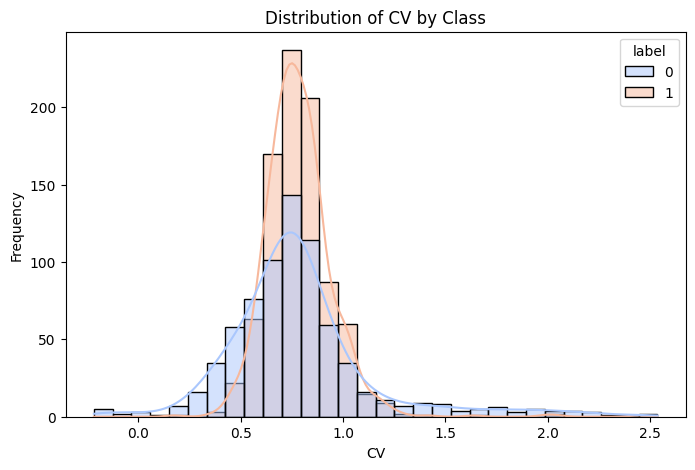

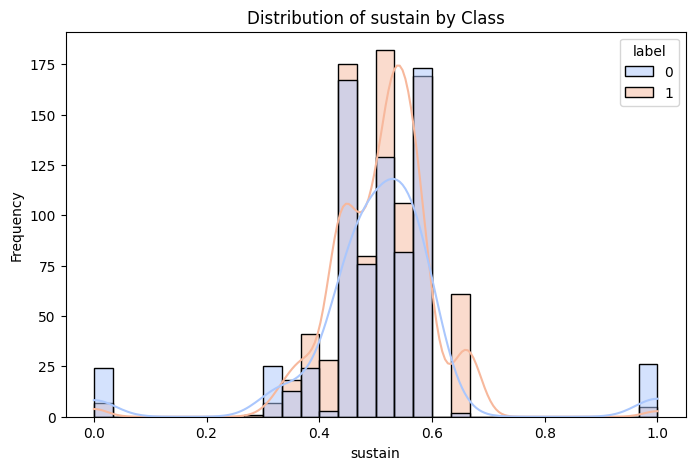

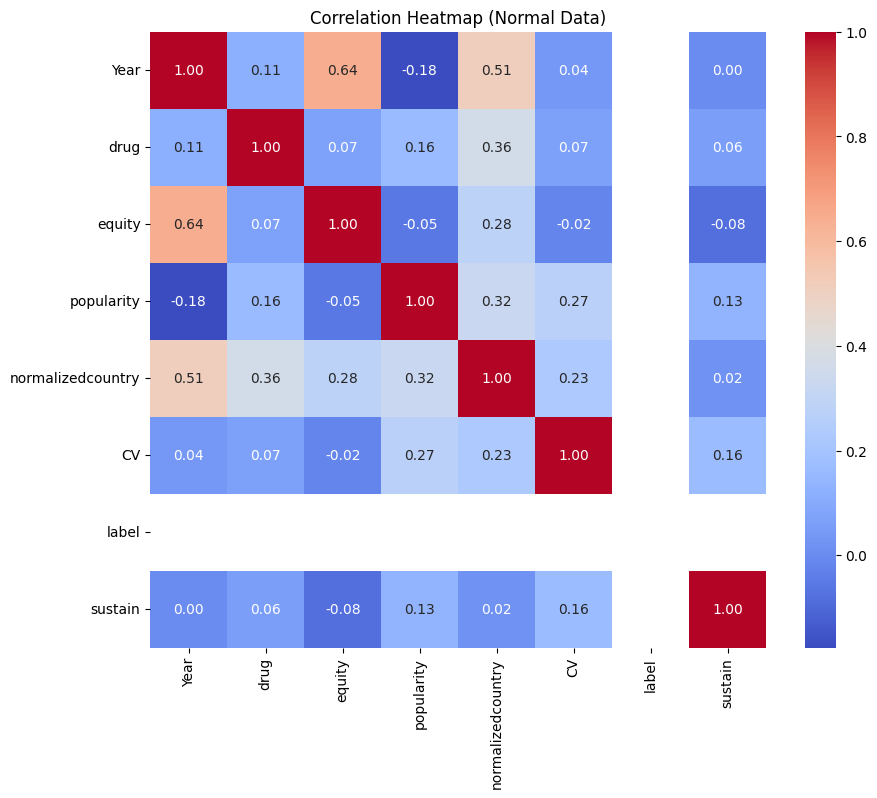

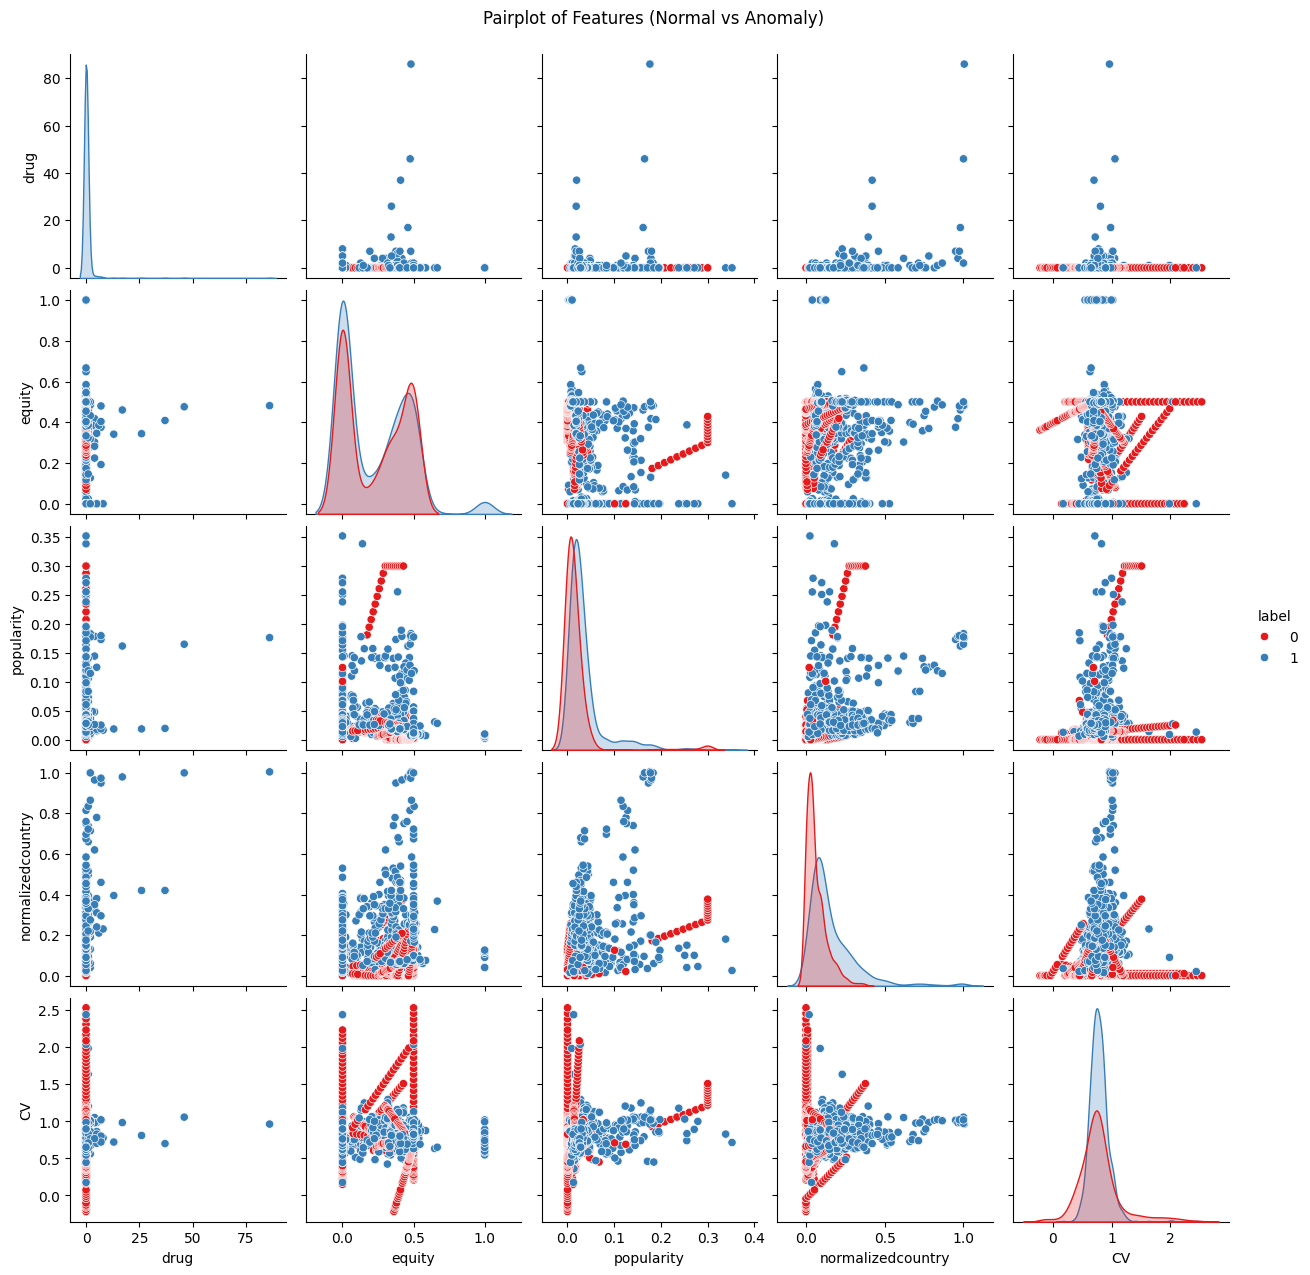

/tmp/ipykernel_56789/1134520909.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=col, data=merged_df, palette='pastel')


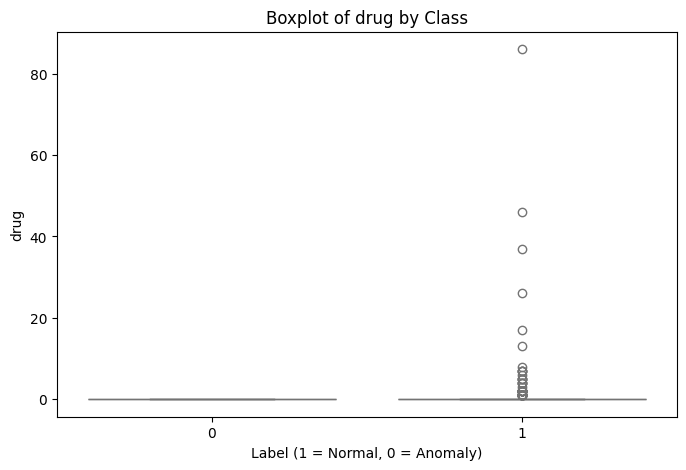

/tmp/ipykernel_56789/1134520909.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=col, data=merged_df, palette='pastel')


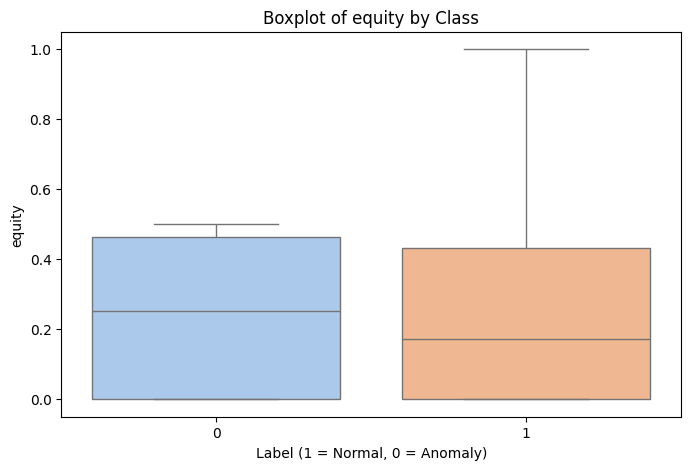

/tmp/ipykernel_56789/1134520909.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=col, data=merged_df, palette='pastel')


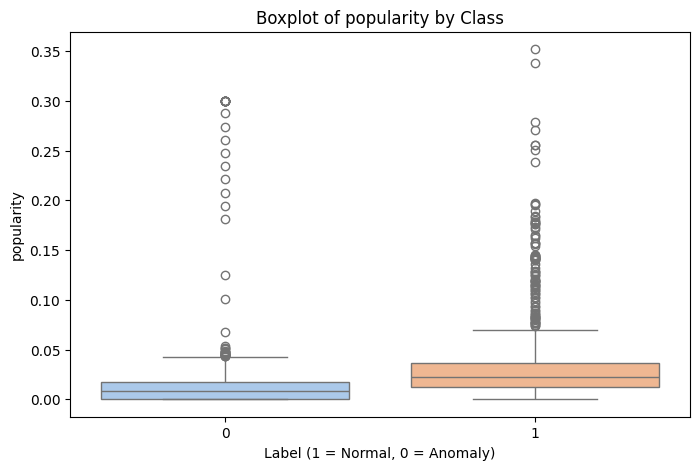

/tmp/ipykernel_56789/1134520909.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=col, data=merged_df, palette='pastel')


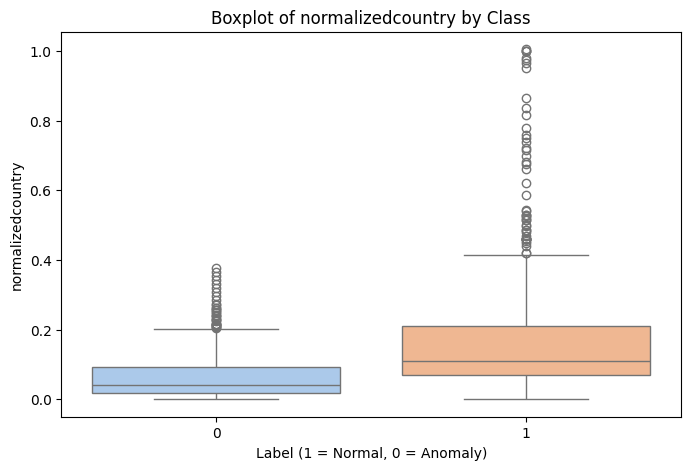

/tmp/ipykernel_56789/1134520909.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=col, data=merged_df, palette='pastel')


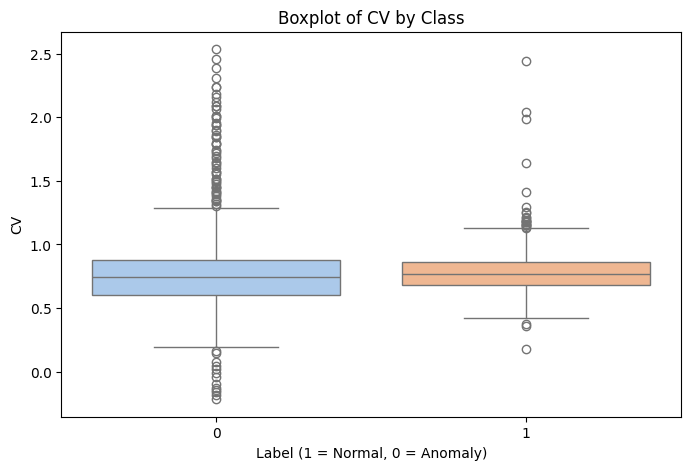

/tmp/ipykernel_56789/1134520909.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=col, data=merged_df, palette='pastel')


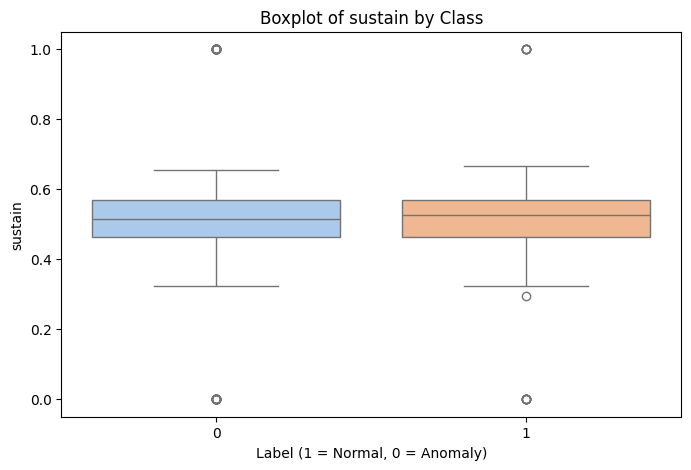

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df is your processed DataFrame
# Ensure the data is loaded
# merged_df = pd.read_csv("your_file.csv")  # Uncomment if loading from CSV

# 1. Check class distribution
print("Class Distribution:")
print(merged_df['label'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=merged_df, palette='viridis')
plt.title("Class Distribution (Normal vs Anomalies)")
plt.xlabel("Label (1 = Normal, 0 = Anomaly)")
plt.ylabel("Count")
plt.show()

# 2. Summary statistics for normal and anomaly classes
print("\nSummary Statistics for Normal Data:")
print(merged_df[merged_df['label'] == 1].describe())

print("\nSummary Statistics for Anomaly Data:")
print(merged_df[merged_df['label'] == 0].describe())

# 3. Visualizing feature distributions for each class
for col in merged_df.columns:
    if col not in ['Year', 'label', 'Sport']:
        plt.figure(figsize=(8, 5))
        sns.histplot(data=merged_df, x=col, hue='label', kde=True, palette='coolwarm', bins=30)
        plt.title(f"Distribution of {col} by Class")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

# 4. Correlation heatmap for normal data (exclude non-numeric columns)
normal_data = merged_df[merged_df['label'] == 1]  # Filter only normal data

# Select only numeric columns for correlation
numeric_columns = normal_data.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap (Normal Data)")
plt.show()


# 5. Pairplot for relationships (use subset to avoid overloading)
subset_cols = [col for col in merged_df.columns if col not in ['Year', 'Sport', 'label']][:5]  # Select first 5 features for clarity
sns.pairplot(merged_df[subset_cols + ['label']], hue='label', palette='Set1', diag_kind='kde')
plt.suptitle("Pairplot of Features (Normal vs Anomaly)", y=1.02)
plt.show()

# 6. Boxplots to identify potential outliers in each feature
for col in merged_df.columns:
    if col not in ['Year', 'label', 'Sport']:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='label', y=col, data=merged_df, palette='pastel')
        plt.title(f"Boxplot of {col} by Class")
        plt.xlabel("Label (1 = Normal, 0 = Anomaly)")
        plt.ylabel(col)
        plt.show()


In [8]:
from sklearn.model_selection import train_test_split

# Drop rows with NaN values in features
features = merged_df.select_dtypes(include=['number']).drop(columns=['label']).dropna()

# Ensure labels align with cleaned features
labels = merged_df['label'][features.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)

print(f"Training data size after dropping NaN: {X_train.shape}")
print(f"Testing data size after dropping NaN: {X_test.shape}")


Training data size after dropping NaN: (1299, 7)
Testing data size after dropping NaN: (325, 7)


In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Custom scorer for GridSearch (using F1 score as an example)
f1_scorer = make_scorer(f1_score, pos_label=1)

# Define hyperparameter grids
iso_forest_params = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.8, 0.6],
    'contamination': [0.05, 0.1, 0.2],
    'random_state': [42]
}

oc_svm_params = {
    'nu': [0.05, 0.1, 0.15],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf', 'poly']
}

ell_env_params = {
    'contamination': [0.05, 0.1, 0.2],
    'support_fraction': [0.8, 0.9, None]
}

# Perform GridSearchCV for Isolation Forest
iso_forest_grid = GridSearchCV(
    IsolationForest(),
    param_grid=iso_forest_params,
    scoring=f1_scorer,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1
)
iso_forest_grid.fit(X_train, y_train)

# Perform GridSearchCV for One-Class SVM
oc_svm_grid = GridSearchCV(
    OneClassSVM(),
    param_grid=oc_svm_params,
    scoring=f1_scorer,
    cv=3,
    n_jobs=-1
)
oc_svm_grid.fit(X_train, y_train)

# Perform GridSearchCV for Elliptic Envelope
ell_env_grid = GridSearchCV(
    EllipticEnvelope(),
    param_grid=ell_env_params,
    scoring=f1_scorer,
    cv=3,
    n_jobs=-1
)
ell_env_grid.fit(X_train, y_train)

# Local Outlier Factor (manual iteration, since it doesn't support predict_proba)
lof_best_params = None
lof_best_f1 = 0
for n_neighbors in [10, 20, 30]:
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.1)
    y_pred_lof = lof.fit_predict(X_test)
    y_pred_lof = [1 if x == 1 else 0 for x in y_pred_lof]  # Convert -1 to 0 (anomaly)
    f1 = f1_score(y_test, y_pred_lof)
    if f1 > lof_best_f1:
        lof_best_f1 = f1
        lof_best_params = {'n_neighbors': n_neighbors}

print(f"Best LOF params: {lof_best_params} with F1 Score: {lof_best_f1}")



/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pr

Best LOF params: {'n_neighbors': 20} with F1 Score: 0.7051282051282052


In [11]:
# Evaluate the best models from GridSearchCV
best_iso_forest = iso_forest_grid.best_estimator_
best_oc_svm = oc_svm_grid.best_estimator_
best_ell_env = ell_env_grid.best_estimator_

# Predictions
y_pred_iso_best = best_iso_forest.predict(X_test)
y_pred_iso_best = [1 if x == 1 else 0 for x in y_pred_iso_best]

y_pred_svm_best = best_oc_svm.predict(X_test)
y_pred_svm_best = [1 if x == 1 else 0 for x in y_pred_svm_best]

y_pred_ell_best = best_ell_env.predict(X_test)
y_pred_ell_best = [1 if x == 1 else 0 for x in y_pred_ell_best]

# Use the best LOF manually chosen
lof = LocalOutlierFactor(n_neighbors=lof_best_params['n_neighbors'], contamination=0.1)
y_pred_lof_best = lof.fit_predict(X_test)
y_pred_lof_best = [1 if x == 1 else 0 for x in y_pred_lof_best]

# Print evaluation metrics
models = {
    "Best Isolation Forest": y_pred_iso_best,
    "Best One-Class SVM": y_pred_svm_best,
    "Best Elliptic Envelope": y_pred_ell_best,
    "Best Local Outlier Factor": y_pred_lof_best
}

for model_name, preds in models.items():
    print(f"--- {model_name} ---")
    print(classification_report(y_test, preds))
    print(f"ROC-AUC: {roc_auc_score(y_test, preds)}\n")


--- Best Isolation Forest ---
              precision    recall  f1-score   support

           0       0.40      0.04      0.07       149
           1       0.54      0.95      0.69       176

    accuracy                           0.53       325
   macro avg       0.47      0.49      0.38       325
weighted avg       0.48      0.53      0.41       325

ROC-AUC: 0.49456604636973767

--- Best One-Class SVM ---
              precision    recall  f1-score   support

           0       0.43      0.06      0.11       149
           1       0.54      0.93      0.68       176

    accuracy                           0.53       325
   macro avg       0.48      0.50      0.39       325
weighted avg       0.49      0.53      0.42       325

ROC-AUC: 0.4961104331909701

--- Best Elliptic Envelope ---
              precision    recall  f1-score   support

           0       0.25      0.03      0.05       149
           1       0.53      0.93      0.68       176

    accuracy                       

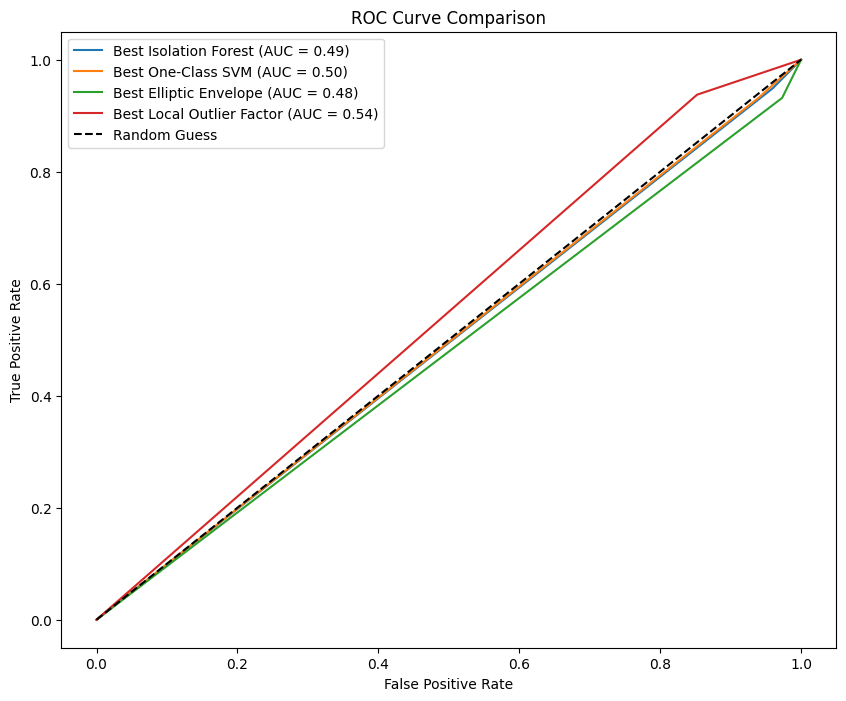

In [12]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for model_name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.show()
